In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math

In [23]:
df=pd.read_csv("speeddating.csv", sep=",")

df.columns

C:\Users\krist\AppData\Local\Temp\ipykernel_20536\552663359.py:1: DtypeWarning: Columns (3,10,11,15,16,17,18,19,39,40,41,42,43,44,51,52,53,54,55,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,107,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("speeddating.csv", sep=",")


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,...,[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1
5,0,1,female,21,25,4,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,5,[6-8],[5-6],0,0,1,0
6,0,1,female,21,30,9,[7-37],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,5,[6-8],[5-6],0,1,0,0
7,1,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,7,[6-8],[7-10],?,0,0,0
8,0,1,female,21,28,7,[7-37],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,7,[6-8],[7-10],0,1,1,1
9,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,0,0


EDA

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_null,8378.0,0.874910,0.330840,0.0,1.0,1.0,1.0,1.0
wave,8378.0,11.350919,5.995903,1.0,7.0,11.0,15.0,21.0
d_age,8378.0,4.185605,4.596171,0.0,1.0,3.0,5.0,37.0
samerace,8378.0,0.395799,0.489051,0.0,0.0,0.0,1.0,1.0
decision,8378.0,0.419909,0.493573,0.0,0.0,0.0,1.0,1.0
decision_o,8378.0,0.419551,0.493515,0.0,0.0,0.0,1.0,1.0
match,8378.0,0.164717,0.370947,0.0,0.0,0.0,0.0,1.0


In [4]:
df.describe(exclude=np.number)

,gender,age,age_o,d_d_age,race,race_o,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
count,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,...,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378
unique,2,31,25,4,6,6,18,16,3,3,...,19,18,3,3,3,19,20,3,3,8
top,male,27,27,[2-3],European/Caucasian-American,European/Caucasian-American,1,1,[2-5],[0-1],...,?,2,[5-6],[0-3],[0-2],7,5,[6-8],[5-6],0
freq,4194,1037,1059,2406,4727,4722,2754,2944,3104,3111,...,6578,1695,4036,7346,4514,1816,1799,4827,3199,7644


In [5]:
#Pozrel som sa ako vyzerajú dáta
df.age.unique()

array(['21', '24', '25', '23', '22', '26', '27', '30', '28', '?', '29',
       '34', '35', '32', '39', '20', '19', '18', '37', '33', '36', '31',
       '42', '38', '55', 23, 24, 30, 28, 27, 25], dtype=object)

In [6]:
#kukol som či tu sú duplikáty
print("Duplicates:")
duplicates = df.duplicated()
print(df[duplicates])


Duplicates:
Empty DataFrame
Columns: [has_null, wave, gender, age, age_o, d_age, d_d_age, race, race_o, samerace, importance_same_race, importance_same_religion, d_importance_same_race, d_importance_same_religion, field, pref_o_attractive, pref_o_sincere, pref_o_intelligence, pref_o_funny, pref_o_ambitious, pref_o_shared_interests, d_pref_o_attractive, d_pref_o_sincere, d_pref_o_intelligence, d_pref_o_funny, d_pref_o_ambitious, d_pref_o_shared_interests, attractive_o, sinsere_o, intelligence_o, funny_o, ambitous_o, shared_interests_o, d_attractive_o, d_sinsere_o, d_intelligence_o, d_funny_o, d_ambitous_o, d_shared_interests_o, attractive_important, sincere_important, intellicence_important, funny_important, ambtition_important, shared_interests_important, d_attractive_important, d_sincere_important, d_intellicence_important, d_funny_important, d_ambtition_important, d_shared_interests_important, attractive, sincere, intelligence, funny, ambition, d_attractive, d_sincere, d_intelligence

Okej, máme missing values v podobe '?' ale nie duplikáty

In [7]:
# Nahrada NaN/<NA> za ?, oprava rôznych data typov v stĺpci, následna oprava opravy naspäť na int z float(kvôli NaN)
df = df.replace("?", np.nan)


#Keďže dropnutie všetkých NaN spôsobí stratu 80% dát, treba imputovať kde sa dá

# match, gender, akékoľvek descison či age sa nedá/nemá zmysel imputovať
# predpokladám že veľmi podstatné pre match bude ako vidí človek druhého človeka, teda nebudem imputovať ani určité vlastnsti s '_o'
critical = [
    'match',
    'gender',
    'age',
    'age_o',
    'decision',
    'decision_o',
    'attractive_o',
    'sinsere_o',
    'intelligence_o',
    'funny_o',
    'ambitous_o',
    'shared_interests_o'
]
df_clean=df.dropna(subset=critical)

df_clean = df_clean.apply(pd.to_numeric, errors='ignore')
df.shape, df_clean.shape
# práve sme dropli asi 18% dát(hopefully ok)

C:\Users\krist\AppData\Local\Temp\ipykernel_20536\287255346.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_clean = df_clean.apply(pd.to_numeric, errors='ignore')


((8378, 123), (6880, 123))

In [8]:
df_clean.select_dtypes(exclude='number').isna().sum()
#Since there is nothing gonna replace missing data with mean or median(depending on outliers)

gender                             0
d_d_age                            0
race                               0
race_o                             0
d_importance_same_race             0
d_importance_same_religion         0
field                              0
d_pref_o_attractive                0
d_pref_o_sincere                   0
d_pref_o_intelligence              0
d_pref_o_funny                     0
d_pref_o_ambitious                 0
d_pref_o_shared_interests          0
d_attractive_o                     0
d_sinsere_o                        0
d_intelligence_o                   0
d_funny_o                          0
d_ambitous_o                       0
d_shared_interests_o               0
d_attractive_important             0
d_sincere_important                0
d_intellicence_important           0
d_funny_important                  0
d_ambtition_important              0
d_shared_interests_important       0
d_attractive                       0
d_sincere                          0
d

Nejaké grafíky na rozhodovanie ohľadom outlierov/hlavných prediktorov

match                         1.000000
decision_o                    0.522783
decision                      0.521392
like                          0.302789
funny_partner                 0.277908
                                ...   
pref_o_sincere               -0.037109
shared_interests_important   -0.040754
pref_o_shared_interests      -0.044978
importance_same_race         -0.054466
d_age                        -0.063084
Name: match, Length: 64, dtype: float64


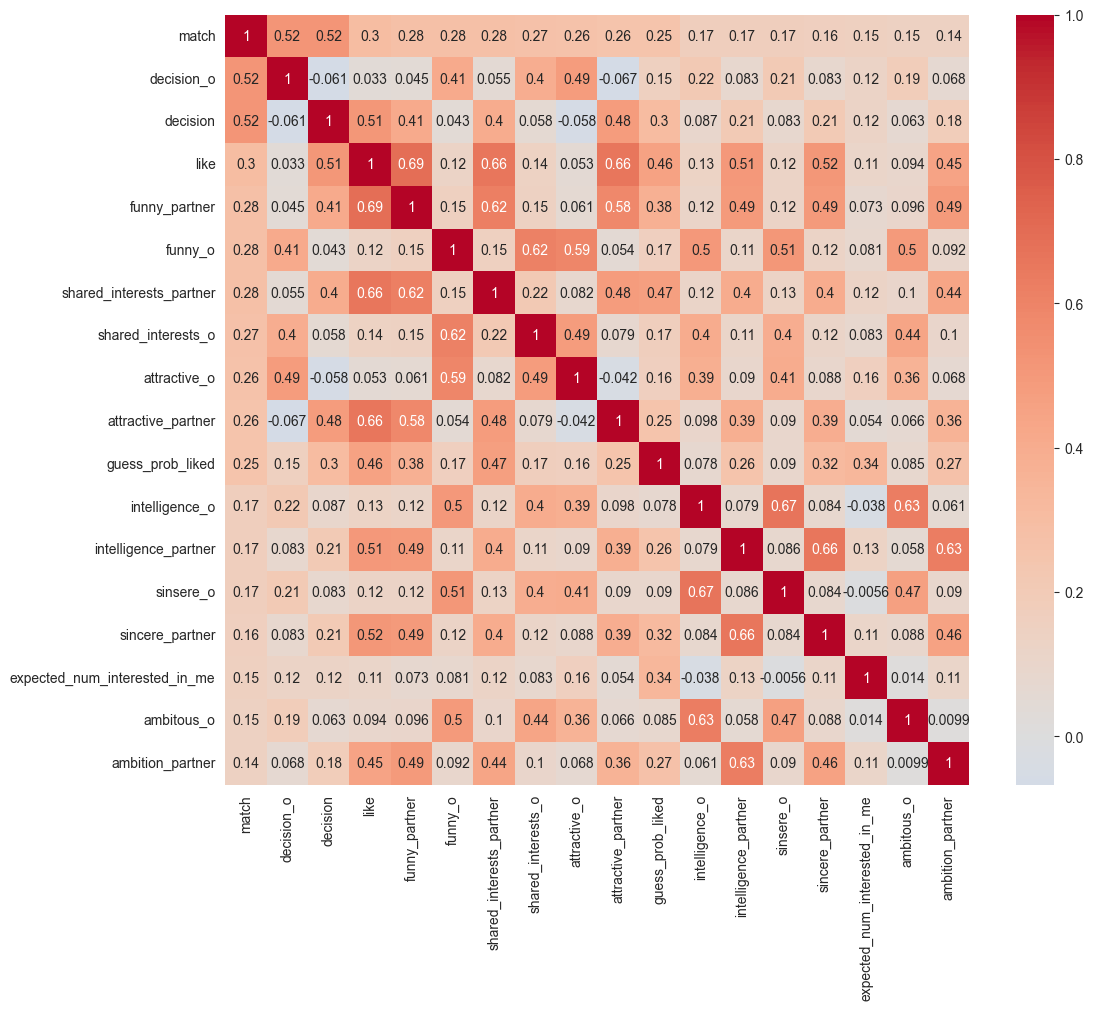

In [9]:
target_corr = df_clean.select_dtypes(include='number').corr()['match'].sort_values(ascending=False)
print(target_corr)
top_features = target_corr.abs().sort_values(ascending=False).head(18).index

plt.figure(figsize=(12,10))
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.show()

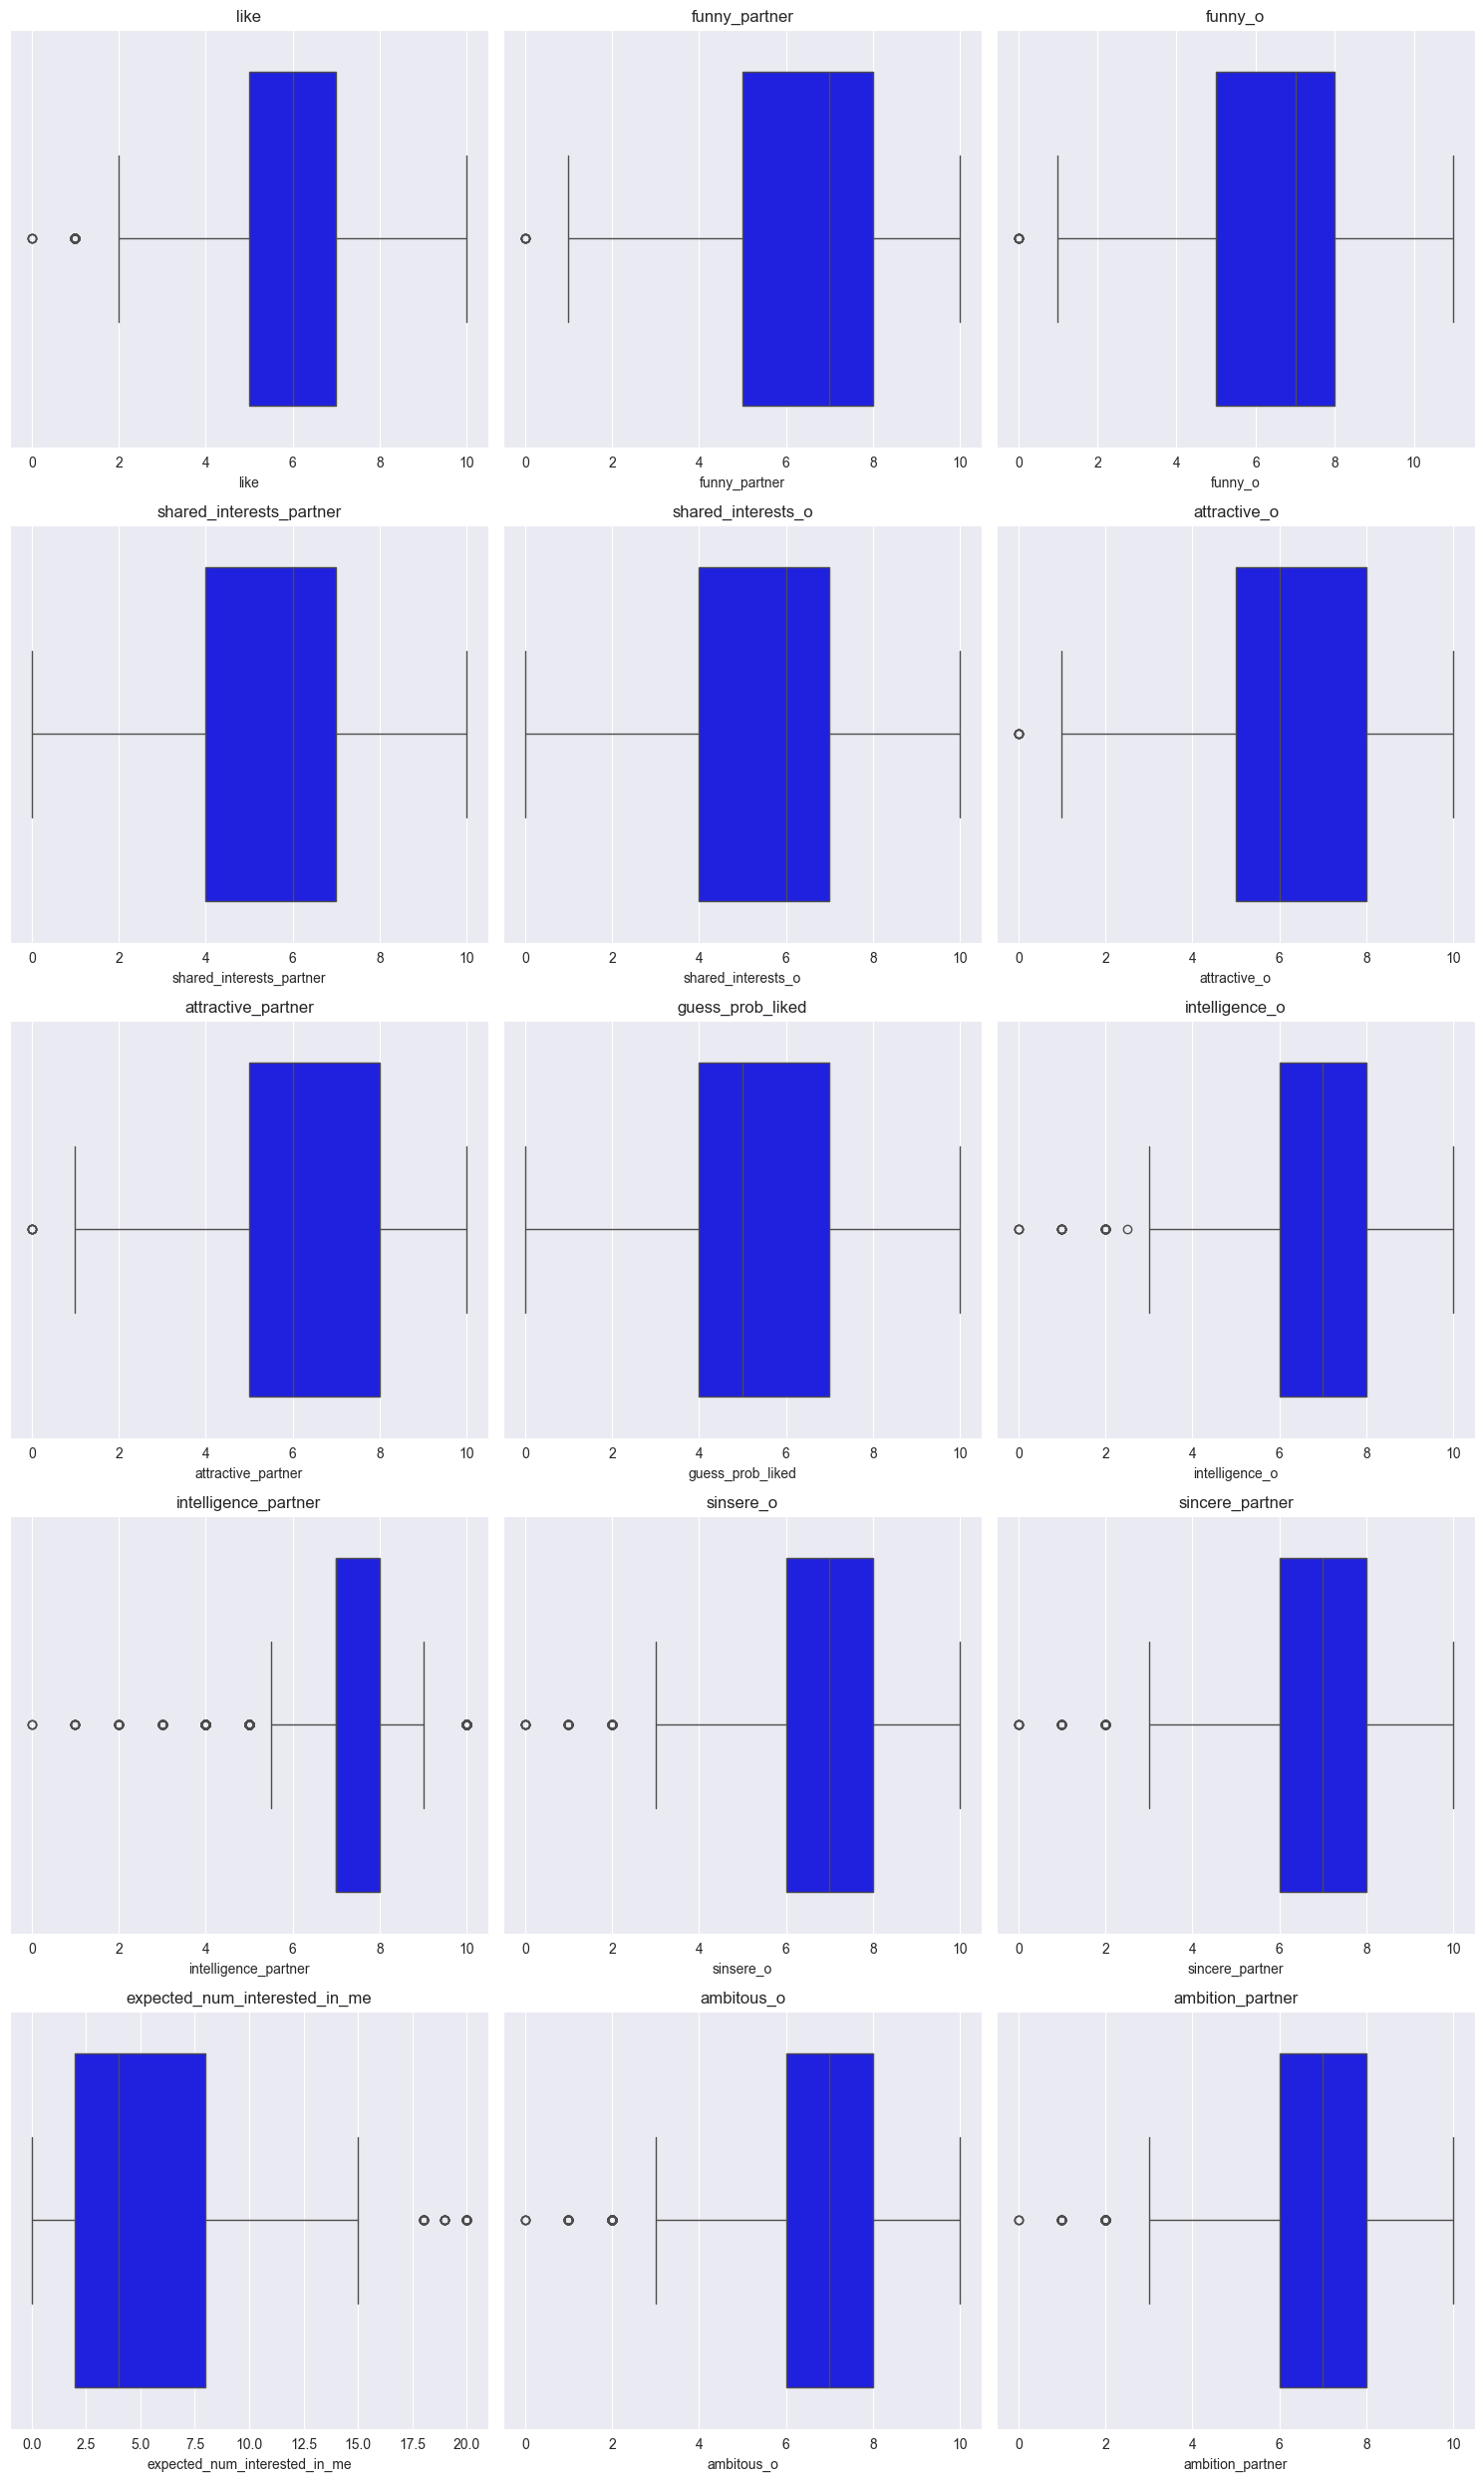

In [10]:
#Boxploty pre najviac korelujúce stĺpce, mimo tie čo majú binárnu hodnotu
cols = [c for c in top_features if df_clean[c].nunique() > 2]

n = len(cols)
rows = math.ceil(n / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    sns.boxplot(x=df_clean[col], ax=ax, color="blue")
    ax.set_title(col)
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Riešenie outlierov

In [11]:
def identify_outliers_z(df, hranica = 3):
    mean = df.mean()
    std = df.std()
    z_skore = (df-mean)/std
    return df[np.abs(z_skore) > hranica]

indexy_z = set()

print("Počet outlierov")
for col in df_clean.select_dtypes(include=[np.number]):
    outliers_z = identify_outliers_z(df_clean[col])
    if len(outliers_z)>0:
        print(f"{col}: {len(outliers_z)}")
        indexy_z.update(outliers_z.index)

Počet outlierov
age: 55
age_o: 44
d_age: 87
pref_o_attractive: 133
pref_o_sincere: 85
pref_o_intelligence: 123
pref_o_funny: 60
pref_o_ambitious: 21
attractive_o: 7
sinsere_o: 43
intelligence_o: 49
funny_o: 12
ambitous_o: 43
attractive_important: 138
sincere_important: 85
intellicence_important: 82
funny_important: 60
ambtition_important: 22
attractive: 18
sincere: 128
intelligence: 55
funny: 77
ambition: 82
attractive_partner: 6
sincere_partner: 39
intelligence_partner: 38
funny_partner: 8
ambition_partner: 36
dining: 62
museums: 13
gaming: 65
reading: 9
theater: 13
movies: 59
concerts: 13
music: 73
interests_correlate: 4
expected_num_matches: 48
like: 4
met: 325
